# Week 8: Recurrent Neural Networks for Sequence Data

We will demonstrate two different approaches to designing RNNs for sequence problem. 

In **Part 1**, we will create a **character-level generative model** using an LSTM to predict the next character,
using sequences of length 20 on a **text file containing Python** code. We will define our LSTM layer as

>  LSTM(..., return_sequence=True)

so that it acts as a **sequence-to-sequence** RNN layer, where each element in the sequence
is an ASCII character ID. Each training step will take a sequence of 20 character IDs (essentially
an N-gram for N = 20) and try to
predict the sequence which occurs if we shift the "20-gram" to the right by one character. The very last
prediction will be the predicted continuation of the input sequence: 

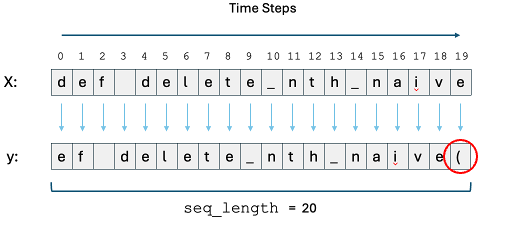

Each LSTM step looks like this:

| Time step | Input ($x_t$) | True target ($y_t$) | Model predicts    | Loss term                                   |
| --------- | ------------- | ------------------- | ----------------- | ------------------------------------------- |
| 0         | `'d'`         | `'e'`               | `'e'` (hopefully) | $L_0 = \text{CrossEntropy}(\hat{y}_0, y_0)$ |
| 1         | `'e'`         | `'f'`               | `'f'`             | $L_1$                                       |
| 2         | `'f'`         | `' '`               | `' '`             | $L_2$                                       |
| ⋮         | ⋮             | ⋮                   | ⋮                 | ⋮                                           |
| 19        | `'e'`         | `'('`               | `'('`             | $L_{19}$                                    |

Then the total loss is:

$$
L = \frac{1}{20} \sum_{t=0}^{19} L_t
$$

In **Part 2**, we will redo our **binary classification task** on the **IMDB Movie Review** dataset from last week, with
the same exact preprocessing steps to encode the reviews as embeddings of length 100, but with an LSTM layer

>  LSTM(..., return_sequence=False)

This is a **sequence-of-vectors to scalar** pattern, where the input is a sequence of word embeddings, as long as the maximum allowed review length,  and the output is a probability. 

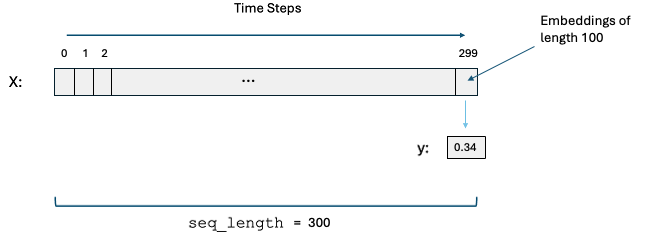



Loss is computed at the last step, in the usual manner. 

## Setup and Data Loading


In [1]:
# ---------- Standard Library ----------
import os
import time
import math
import random
from pathlib import Path
from collections import Counter

# Environment (set BEFORE importing TensorFlow)
os.environ["PYTHONHASHSEED"] = "0"        # Disable hash randomization
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Deterministic TF ops where possible
os.environ["TF_CUDNN_DETERMINISM"] = "1"  # Deterministic CuDNN (if GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress TF INFO/WARNING logs

# ---------- Third-Party (General) ----------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit, ShuffleSplit
import kagglehub

# ---------- TensorFlow / Keras ----------
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import GlobalMaxPooling1D, SpatialDropout1D, Bidirectional
# Layers (vision)
from tensorflow.keras.layers import (
    Input, Conv2D,Conv1D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    GlobalMaxPooling2D, BatchNormalization, ReLU, Flatten, Dense, Dropout
)

# Preprocessing (vision)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ---------- (Optional) NLP-related imports ----------
# If not doing NLP, you can safely remove this block.
from tensorflow.keras.layers import (
    Embedding, GlobalAveragePooling1D, LSTM, GRU, SpatialDropout1D, Bidirectional, Lambda
)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.datasets import imdb  # uncomment only if needed

# ---------- Reproducibility ----------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)  # covers TF, Python, and NumPy RNGs

# ---------- Convenience ----------
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

def format_hms(seconds: float) -> str:
    """Format seconds as H:MM:SS."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# Example:
# start = time.time()
# ... your code ...
# print("Elapsed:", format_hms(time.time() - start))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        # print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task. 
- Assumes `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables, or can specify them when calling
    - If you don’t pass X_train, it will look in the global namespace at call time.
    - If you do pass an explicit X_train=..., that value takes priority.
  
>      # uses global X_train, y_train, ...
>      train_and_test(model)
>
>      # uses explicitly passed datasets
>      train_and_test(model, X_train=new_X, y_train=new_y)

In [3]:
def train_and_test(
    model,
    X_train=None, y_train=None,
    X_val=None,   y_val=None,
    X_test=None,  y_test=None,
    *,
    epochs=100,
    optimizer="Adam",
    lr_schedule=1e-3,
    clipnorm=1.0,                   # recommended for LSTM
    loss="binary_crossentropy",     # For binary classification task
    metrics=("accuracy",),
    validation_split=0.2,            # fraction to carve from train if no (X_val,y_val)
    random_state=42,                 # used for internal splits
    title="Learning Curves",
    batch_size=128,
    use_early_stopping=True,
    patience=10,
    min_delta=1e-4,
    callbacks=None,
    verbose=0,
    return_history=False,
):
    # Resolve datasets lazily from globals if not provided
    g = globals()
    X_train = X_train if X_train is not None else g.get("X_train")
    y_train = y_train if y_train is not None else g.get("y_train")
    X_val   = X_val   if X_val   is not None else g.get("X_val")
    y_val   = y_val   if y_val   is not None else g.get("y_val")
    X_test  = X_test  if X_test  is not None else g.get("X_test")
    y_test  = y_test  if y_test  is not None else g.get("y_test")

    # Basic checks
    if X_train is None or y_train is None:
        raise ValueError("Training data (X_train, y_train) not provided or defined globally.")
    if X_test is None or y_test is None:
        raise ValueError("Test data (X_test, y_test) not provided or defined globally.")

    # If no explicit val provided, optionally create one from training
    made_internal_val = False
    if X_val is None or y_val is None:
        if validation_split and validation_split > 0.0:
            # Convert to arrays for splitting
            X_tr = np.asarray(X_train)
            y_tr = np.asarray(y_train)
            test_size = float(validation_split)

            if _is_single_label_classification(y_tr):
                splitter = StratifiedShuffleSplit(
                    n_splits=1, test_size=test_size, random_state=random_state
                )
                (train_idx, val_idx), = splitter.split(X_tr, y_tr)
            else:
                splitter = ShuffleSplit(
                    n_splits=1, test_size=test_size, random_state=random_state
                )
                (train_idx, val_idx), = splitter.split(np.arange(len(X_tr)))

            X_train, y_train = X_tr[train_idx], y_tr[train_idx]
            X_val,   y_val   = X_tr[val_idx],   y_tr[val_idx]
            made_internal_val = True
        else:
            # No validation available and no split requested
            if use_early_stopping:
                raise ValueError(
                    "Early stopping needs validation. Provide (X_val, y_val) or set validation_split > 0."
                )

    # Title (optional)
    if title:
        print(f"\n{title}\n")

    # Build & compile
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=clipnorm)
    model.compile(optimizer=opt, loss=loss, metrics=list(metrics))

    # Callbacks
    if callbacks is None:
        callbacks = []
    if use_early_stopping:
        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                patience=patience,
                min_delta=min_delta,
                restore_best_weights=True,
                verbose=verbose,
            )
        ] + callbacks

    # Fit
    start = time.time()
    fit_kwargs = dict(
        x=X_train, y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
        shuffle=True,  # explicit
    )

    if X_val is not None and y_val is not None:
        fit_kwargs["validation_data"] = (X_val, y_val)
    else:
        # Note: we only arrive here if validation_split==0 and early stopping is off.
        pass

    history = model.fit(**fit_kwargs)

    # Find best epoch
    hist = history.history
    if "val_accuracy" in hist:
        best_epoch = int(np.argmax(hist["val_accuracy"]))
        best_val_metric = float(hist["val_accuracy"][best_epoch])
        best_metric_name = "val_accuracy"
    elif "val_loss" in hist:
        best_epoch = int(np.argmin(hist["val_loss"]))
        best_val_metric = float(hist["val_loss"][best_epoch])
        best_metric_name = "val_loss"
    else:
        best_epoch = len(hist.get("loss", [])) - 1
        best_val_metric = float("nan")
        best_metric_name = "val_metric"

    # Optional plot
    try:
        plot_learning_curves(history, title=title)
    except NameError:
        pass

    # Evaluate on test
    test_out = model.evaluate(X_test, y_test, verbose=0)
    metric_names = model.metrics_names
    test_results = dict(zip(metric_names, map(float, np.atleast_1d(test_out))))

    if verbose:
        print(f"\nBest {best_metric_name} Overall: {best_val_metric:.4f} @ epoch {best_epoch}")

        # if "accuracy" in test_results and np.isfinite(best_val_metric):
        #     gap = abs(best_val_metric - test_results["accuracy"])
        #     print(f"\nTest Loss: {test_results.get('loss', float('nan')):.4f}")
        #     print(f"Test Accuracy: {test_results['accuracy']:.4f}")
        #     print(f"\nValidation–Test Gap (accuracy): {gap:.6f}")
        # else:
        #     print(f"\nTest metrics: {test_results}")

    end = time.time()
    try:
        print(f"\nExecution Time: {format_hms(end - start)}")
    except NameError:
        print(f"\nExecution Time: {end - start:.2f}s")

    result = {
        "title": title,
        "best_epoch": best_epoch,
        "best_val_name": best_metric_name,
        "best_val_value": best_val_metric,
        "made_internal_val": made_internal_val,
        "test": test_results,
    }

    if return_history:
        return (result, history) 


def _is_single_label_classification(y, max_classes_for_stratify=50):
    """
    Heuristic: stratify only if y is 1D, integral/categorical-like, and not too many classes.
    """
    y = np.asarray(y)
    if y.ndim != 1:
        return False
    # try to interpret as integers (e.g., 0..K-1); accept bool as well
    if np.issubdtype(y.dtype, np.integer) or np.issubdtype(y.dtype, np.bool_):
        pass
    else:
        # floats might still be ints (e.g., 0., 1.) — check it
        y_intish = np.all(np.equal(np.mod(y, 1), 0))
        if not y_intish:
            return False
        y = y.astype(int)
    n_classes = np.unique(y).size
    return 2 <= n_classes <= max_classes_for_stratify



### Learning Rate Schedulers

In [4]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

In [5]:
# Both these must be input as lr_schedule in train_and_test(....   , lr_schedule=exp_decay, .... )

epochs = 100               # You'll need to adjust this to close to be close to the early stopping location
batch_size = 128

# Needed by LR schedulers

'''
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch


exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001,  #  the starting learning rate (before any decay)
    decay_steps=total_steps,     #  how many training steps (batches) before applying decay
    decay_rate=0.98,              #  multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             #  if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #  if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.0001, #  the starting learning rate
    decay_steps=total_steps,      #  number of training steps (batches) over which to decay
    alpha=0.0,                    #  minimum learning rate value as a fraction of initial_learning_rate
                                  #  (final_lr = initial_lr * alpha)
)
'''
None

## Part 1:  Character-Level Text Generation

We'll run a simple LSTM network to create a generative model producing Python code, character by character.

### Load text & build a character vocabulary

In this cell we:

1. **Read the corpus** from `python_code.txt` and cap it to a small size (`text_length`) so training runs quickly.
2. **Build a character-level vocabulary**: take the set of all unique characters in the text and sort them for a stable, reproducible index order.
3. **Create lookup tables**:

   * `char2int`: maps each character → integer ID `0..vocab_size-1`
   * `int2char`: inverse mapping for decoding IDs back to text
4. **Define helpers**:

   * `encode(s)` turns a string into a NumPy `int32` array of IDs
   * `decode(ids)` turns an array of IDs back into a string
5. **Integer-encode the entire corpus** to `encoded_text`, which is what the model will actually see.
6. **Preview** the first 200 raw characters and their corresponding codes.

> Notes:  
> • This is **character-level** tokenization (each distinct Unicode character is a token).    
> • `vocab_size` will be used to size the one-hot/embedding layer later.    
> • If you want lowercase/whitespace normalization, do it **before** building the vocabulary so the mappings stay consistent.


In [6]:
# 1) Load text and cap length (use your own file)
with open('python_code.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# text_length = 264_802  # full size
text_length = 20_000   # keep small for quick demo

raw_text = raw_text[:text_length]
print(raw_text[:200])

# 2) Build vocabulary and encoders
chars = sorted(set(raw_text))
vocab_size = len(chars)
print(f"\nVocab size: {vocab_size}")

char2int = {c: i for i, c in enumerate(chars)}
int2char = np.array(chars)

def encode(s: str) -> np.ndarray:
    return np.array([char2int[c] for c in s], dtype=np.int32)

def decode(ids) -> str:
    ids = np.asarray(ids, dtype=np.int64)
    return ''.join(int2char[ids])

encoded_text = encode(raw_text)

def delete_nth_naive(array, n):
    ans = []
    for num in array:
        if ans.count(num) < n:
            ans.append(num)
    return ans

def delete_nth(array, n):
    result = []
    counts = col

Vocab size: 70


#### Create training dataset

We build a **teacher-forcing** dataset for character-level next-token prediction. The fundamental idea is that we will
use the LSTM layer as a **seq2seq** predictor as described in the introduction.  

The process is essentially the same as creating a **sequence of N-grams for N = 20.** 

### What the LSTM actually “sees” and “remembers”

* At each time step, it receives **one character embedding** (say a 1-hot vector or dense embedding).
* It updates its **hidden state** ($h_t$) and **cell state** ($c_t$) — this is how it remembers previous context.
* The prediction at time $t$ (the probability distribution over all possible next characters) is produced from $h_t$:
  $$
  \hat{y}_t = \text{softmax}(W h_t + b)
  $$

So while the immediate target is just the next letter, the prediction is *context-dependent* — the LSTM carries information about everything it has seen up to that point.

---

### End of the sequence

* Input: `'d e f d e l e t e _ n t h _ n a i v e'`
* Target: `'e f d e l e t e _ n t h _ n a i v e ('`
* So after training, when you feed it `'def delete_nth_naive'`,
  it will *learn* that `'('` is the most likely next character.



In [7]:
# Make (X, y) with TEACHER FORCING (sequence -> sequence, shifted by 1)

seq_length = 20
N = len(encoded_text) - seq_length
X = np.zeros((N, seq_length), dtype=np.int32)        # (N, T)
y = np.zeros((N, seq_length), dtype=np.int32)        # (N, T) integer class ids

for i in range(N):
    X[i] = encoded_text[i:i+seq_length]              # inputs: positions i..i+T-1
    y[i] = encoded_text[i+1:i+seq_length+1]          # targets: positions i+1..i+T

print(f"\nSequence length: {seq_length}")
print(f"X.shape: {X.shape}  y.shape: {y.shape}")

print("\nExample (decoded):")
print(decode(X[0]), " -> ", decode(y[0]))


Sequence length: 20
X.shape: (19980, 20)  y.shape: (19980, 20)

Example (decoded):
def delete_nth_naive  ->  ef delete_nth_naive(


### Model overview (teacher forcing, char-level)

We train a **character-level autoregressive model** using **teacher forcing**, where the model learns to predict the next character at each time step given all previous ones.

**Architecture summary:**

(I am leaving out the number of batchs in the tensor for simplicity.)

* **Input** — tensor of integer token IDs with shape **(20,)**.
* **Embedding(70, 256)** — maps each character ID to a dense 256-dimensional vector → **(20, 256)**.
* **LSTM(256, return_sequences=True)** — processes the sequence and outputs one hidden state per time step → **(20, 256)**.
* **Dense + Softmax** — projects each hidden state to a probability distribution over the next character → **(20, 70)**.
* **Targets** — the same sequence shifted by one position (shape **(20,)**, integer IDs).
* **Loss / Metric** — `sparse_categorical_crossentropy` and `sparse_categorical_accuracy`, both averaged across time steps.
* **Stability** — gradient clipping (`clipnorm = 1.0`) in Adam prevents occasional exploding gradients in long sequences.

> The `Embedding` layer replaces one-hot encoding, greatly reducing parameters and improving efficiency even for moderate vocabularies.



In [8]:
# Model: integer IDs -> Embedding -> LSTM -> softmax at each timestep
model = Sequential([
    Input(shape=(seq_length,), dtype='int32'),           # (B, T) integer-encoded input
    Embedding(vocab_size, 256),                          # (B, T, 256) dense learned vectors
    LSTM(256, return_sequences=True),                    # (B, T, 256) hidden state for each step
    Dense(vocab_size, activation='softmax')              # (B, T, V) predicted next-char probs
])


model.compile(
    optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),            # clip for RNN stability
    loss='sparse_categorical_crossentropy',                      # integer targets
    metrics=['sparse_categorical_accuracy']                      # averaged over timesteps
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 256)        │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 70)         │        17,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,222 (2.14 MB)

 Trainable params: 561,222 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

### Generating text

We generate text **autoregressively** (one character at a time):

1. **Seed**: start with a `seed_ids` sequence of length `seq_length` (the last `T` chars of some text).
2. **Predict**: run the model on the seed and take the **last timestep** distribution over the vocabulary.
3. **Sample**: optionally apply a **temperature** to the logits, then sample the next character index from the softmax.
4. **Append & slide**: append the sampled index to the sequence, then keep only the **last `seq_length`** positions as the new seed.
5. **Repeat** until you’ve produced the desired number of characters.

> Notes:
> • Lower temperature (e.g., 0.7) → safer, more predictable text; higher (e.g., 1.2) → more creative, but messier.
> • Using `argmax` instead of sampling can make output repetitive; sampling usually reads better.


In [9]:
# Sampling function (uses last timestep distribution)
def sample(model, seed_ids, length=400, temperature=1.0):
    generated = list(seed_ids)
    for _ in range(length):
        x = np.array([generated[-seq_length:]], dtype=np.int32)  # (1, 20)    Input to model for prediction
        probs = model.predict(x, verbose=0)                      # (20,70)    prob distributions for each step in sequence
        probs = probs[0, -1] if probs.ndim == 3 else probs[0]    # (20,)      grabs the last distribution (for predicted char) for softmax

        # temperature scaling (stable)
        logits = np.log(probs + 1e-8) / max(temperature, 1e-8)
        logits -= logits.max()
        probs = np.exp(logits); probs /= probs.sum()

        next_idx = np.random.choice(np.arange(vocab_size), p=probs)
        generated.append(next_idx)
    return decode(generated)

# Quick sanity check (no training yet, just to ensure shapes flow)
sample(model, encoded_text[:seq_length], length=10, temperature=1.0)

### Train Model and Generate Text after each Epoch

We will see how well the model does after each epoch!

In [10]:
# Train and sample after each epoch
total_epochs = 15
batch_size = 64
history_loss = []

for epoch in range(total_epochs):
    hist = model.fit(X, y, batch_size=batch_size, epochs=1, shuffle=True, verbose=0)
    history_loss.extend(hist.history['loss'])

    seed = encoded_text[:seq_length]
    print(f"\n--- Sample after epoch {epoch+1} ---\n")
    print(sample(model, seed, length=300, temperature=1.0))


--- Sample after epoch 1 ---

def delete_nth_naive(toan_conde)
          bos = c3:
       orstar < cons[], r)= 0
               fon_return

    return Nongen(strrack[ro):
        sum_ck(re)
    umme_nfing, ie, p))
    res >= ling(+istartaton += "
    fon array= 0
    return re
    re inevlelt < tri:
    for corroarray[r] + ")
    on boar * indx)
  

--- Sample after epoch 2 ---

def delete_nth_naive(antpric, pos):
            j = 0
    "7": " + 2j+", logte *   ef s b:
    j = nv:
        return
    return res

    def mals = 0
    tur + [] "        cur = {
    y == len(er)
        if valser(surt <= + 1 v20(string):
lseftr[elue = carray[i] = -1
        start], arr[board[[]] + 1
            back

--- Sample after epoch 3 ---

def delete_nth_naive(nums[1:], dic):
    if count % 1
    restart = max_len = 0
    for used is ans None:
         return compatelte_str(n, arr[B, string)):
    res = []
        curr = []
    []
    used_"hrack[bkar]], 0],
            start_idx -= 1

def max_length

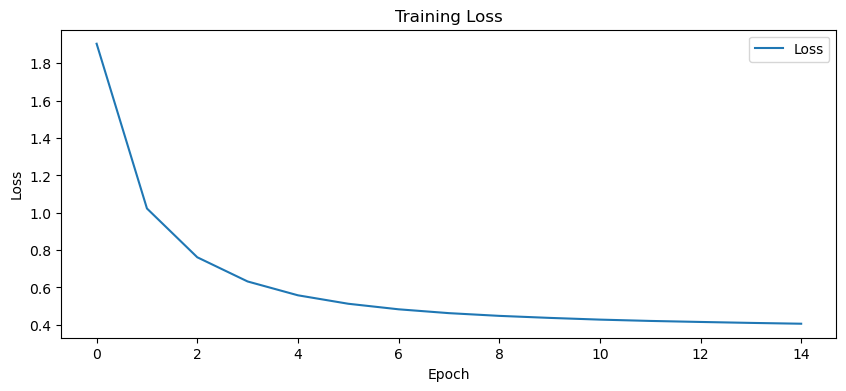

In [11]:
# 7) Plot training loss
plt.figure(figsize=(10,4))
plt.plot(history_loss, label='Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss'); plt.legend(); plt.show()

## Part 2:  Movie Review Task with IMDB Dataset


Now we will show how to do classification using an LSTM network. We'll use the Movie Review Dataset from last week's Coding Notebook for comparison. 

In [12]:
training_vocabulary_size = 20_000    # Cool, Python ignores underscores in integers, so you can use this for 20,000 for readability 

(X_tr, y_tr), (X_te, y_te) = imdb.load_data( num_words = training_vocabulary_size )     # use imdb.load_data() to load all words     

#### Train-Test Split

The dataset as we download it is pre-split 50 : 50 into training and testing sets. We prefer to use the more standard 80 : 20 split, so we'll combine and do our own split, stratifying as usual for classification. 

In [13]:
X  = np.concatenate([X_tr, X_te], axis=0)
y  = np.concatenate([y_tr, y_te], axis=0)

print(f"Total samples: {len(X)}") 

# 80 / 20 stratified split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)
print(f"Train samples: {len(X_train)},  Test samples: {len(X_test)}")  

Total samples: 50000
Train samples: 40000,  Test samples: 10000


In [14]:
# Set maximum review length and pad/truncate sequences

max_text_length = 300

X_train = pad_sequences(
    X_train,
    maxlen=max_text_length,
    padding='post',     # pad with zeros at end of each sequence < max_text_length; 'pre' would pad at beginning
    truncating='post'   # drop tokens at end if sequence > max_text_length; 'pre' would drop tokens at beginning
)

X_test = pad_sequences(
    X_test,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)

print(X_train.shape, X_train.dtype)

(40000, 300) int32


#### Load the GLoVe vectors

In [15]:
embedding_dimension = 100             # adjust dimension if needed

glove_path = Path(f"glove.6B/glove.6B.{embedding_dimension}d.txt")  

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')

print(f"GloVe words loaded: {len(embeddings_index):,}")

GloVe words loaded: 400,000


#### Build the Embedding Matrix

In [16]:
word_index      = imdb.get_word_index()

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))

for word, raw_idx in word_index.items():
    idx = raw_idx + 3                            # shift by 3 to match Keras’s token IDs
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

nonzero = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Coverage: {nonzero/training_vocabulary_size:.1%} of vocabulary has a pre-trained vector")
print(f"Embedding Matrix shape: {embedding_matrix.shape}")

Coverage: 95.6% of vocabulary has a pre-trained vector
Embedding Matrix shape: (20000, 100)


#### Define several models and train

**Baseline model 01: Single LSTM 128 wide**


Model 01

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5118 - loss: 0.6948 - val_accuracy: 0.5250 - val_loss: 0.6845
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5386 - loss: 0.6808 - val_accuracy: 0.5784 - val_loss: 0.6377
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6126 - loss: 0.6346 - val_accuracy: 0.8445 - val_loss: 0.4053
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8513 - loss: 0.4053 - val_accuracy: 0.8712 - val_loss: 0.3715
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8572 - loss: 0.3755 - val_accuracy: 0.8637 - val_loss: 0.3799
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8858 - loss: 0.3264 - val_accuracy: 0.8645 - val_loss: 0.3709
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9046 - loss: 0.2830 - val_accuracy: 0.8680 - val_loss: 0.3766
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.897

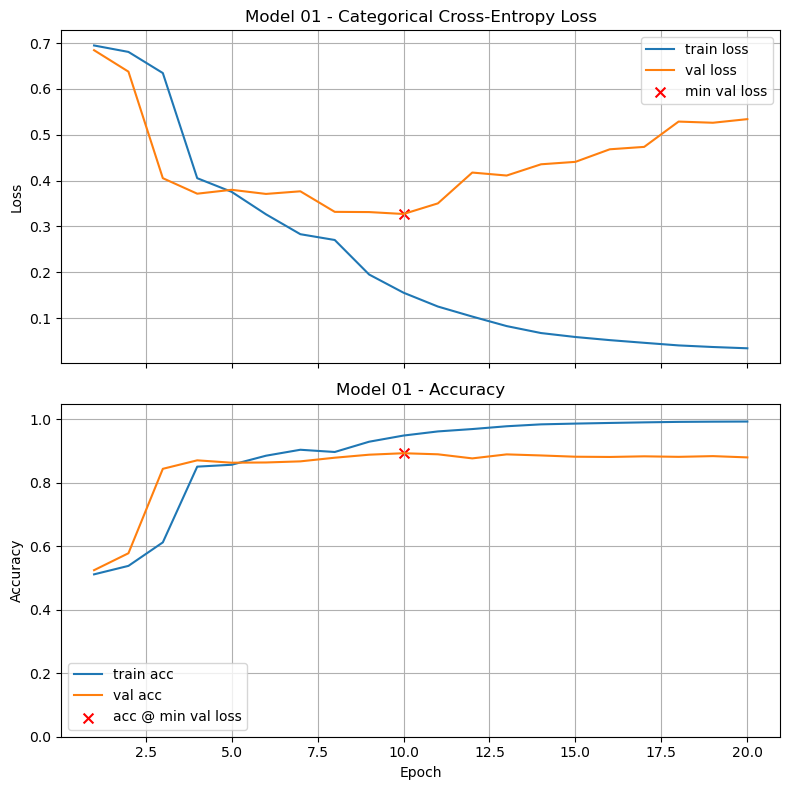

Final Training Loss:            0.0341
Final Training Accuracy:        0.9935
Final Validation Loss:          0.5341
Final Validation Accuracy:      0.8805
Validation Accuracy @ Min Loss: 0.8936

Best val_accuracy Overall: 0.8936 @ epoch 9

Execution Time: 00:03:18


In [17]:
model_01 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'), # Input an array of token IDs
    Embedding(
            input_dim  = training_vocabulary_size,  # e.g. 20_000
            output_dim = embedding_dimension,       # e.g. 100
            weights    = [embedding_matrix],
            mask_zero  = True,                       # ignore <PAD> in pooling -- this makes a huge difference in training speed!
            trainable  = True                  # freeze or unfreeze embedding weights
        ),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_01,title="Model 01",verbose=1)

**Model 02: Model 01 plus Spatial Dropout after embedding layer**


Model 02

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5091 - loss: 0.6955 - val_accuracy: 0.5059 - val_loss: 0.6912
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5221 - loss: 0.6890 - val_accuracy: 0.5614 - val_loss: 0.6635
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5555 - loss: 0.6702 - val_accuracy: 0.5574 - val_loss: 0.6592
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6244 - loss: 0.6122 - val_accuracy: 0.8414 - val_loss: 0.4201
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8416 - loss: 0.3970 - val_accuracy: 0.8664 - val_loss: 0.3712
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8897 - loss: 0.2954 - val_accuracy: 0.8792 - val_loss: 0.3213
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9054 - loss: 0.2543 - val_accuracy: 0.8846 - val_loss: 0.3008
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9206 - los

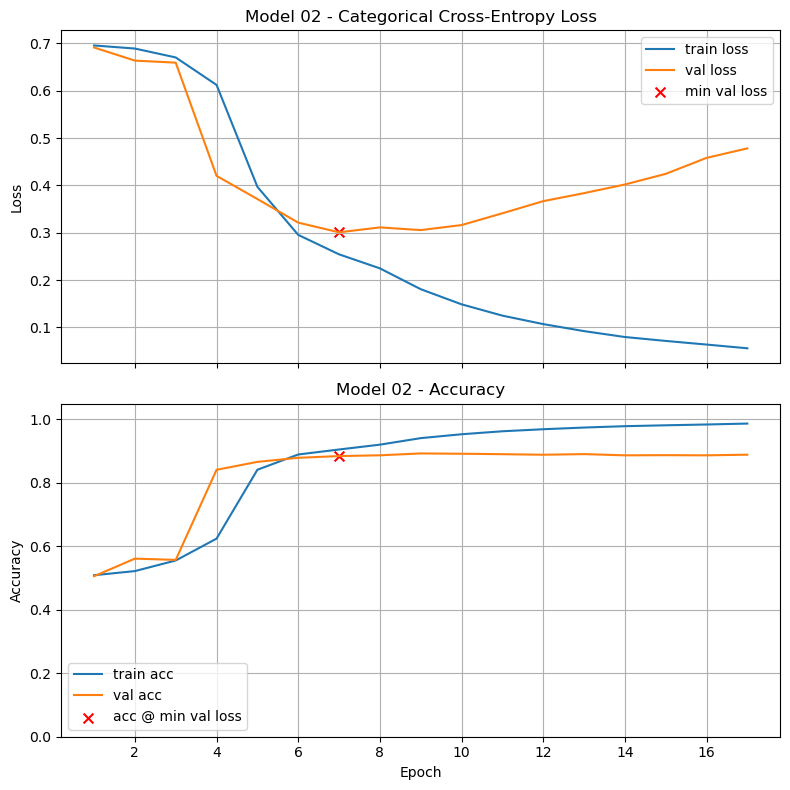

Final Training Loss:            0.0559
Final Training Accuracy:        0.9871
Final Validation Loss:          0.4781
Final Validation Accuracy:      0.8890
Validation Accuracy @ Min Loss: 0.8846

Best val_accuracy Overall: 0.8930 @ epoch 8

Execution Time: 00:02:34


In [18]:
model_02 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,       # e.g. 100
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    SpatialDropout1D(0.2),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_02,title="Model 02",verbose=1)


**Model 03: Bidirectional LSTM 128 wide with dropout 0.3**


Model 03

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 145ms/step - accuracy: 0.5122 - loss: 0.6967 - val_accuracy: 0.5339 - val_loss: 0.6828
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.5294 - loss: 0.6863 - val_accuracy: 0.5569 - val_loss: 0.6654
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.5587 - loss: 0.6636 - val_accuracy: 0.5779 - val_loss: 0.6240
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.7384 - loss: 0.5154 - val_accuracy: 0.8459 - val_loss: 0.4179
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.8492 - loss: 0.4131 - val_accuracy: 0.8319 - val_loss: 0.4200
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.8068 - loss: 0.4426 - val_accuracy: 0.8407 - val_loss: 0.3823
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.8886 - loss: 0.2801 - val_accuracy: 0.8866 - val_loss: 0.2986
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accurac

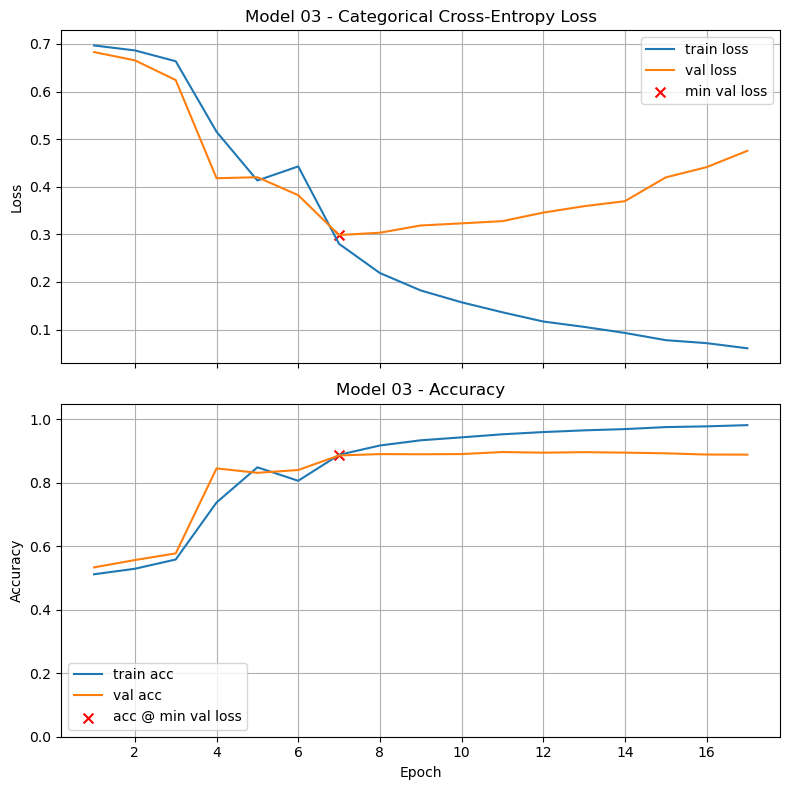

Final Training Loss:            0.0607
Final Training Accuracy:        0.9822
Final Validation Loss:          0.4754
Final Validation Accuracy:      0.8892
Validation Accuracy @ Min Loss: 0.8866

Best val_accuracy Overall: 0.8974 @ epoch 10

Execution Time: 00:10:21


In [19]:
# optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=1.0)

model_03 = models.Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim=training_vocabulary_size,
        output_dim=embedding_dimension,       # 100
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    Bidirectional(LSTM(128, dropout=0.3, return_sequences=False)),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_03,title="Model 03",verbose=1)

**Model 04: Bidirectional LSTM 128 with spatial dropout and global max pooling**


Model 04

Epoch 1/100


/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 268ms/step - accuracy: 0.6906 - loss: 0.5609 - val_accuracy: 0.8610 - val_loss: 0.3207
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.8557 - loss: 0.3399 - val_accuracy: 0.8836 - val_loss: 0.2777
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.8860 - loss: 0.2783 - val_accuracy: 0.8954 - val_loss: 0.2559
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.9005 - loss: 0.2445 - val_accuracy: 0.8957 - val_loss: 0.2586
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 264ms/step - accuracy: 0.9178 - loss: 0.2097 - val_accuracy: 0.9030 - val_loss: 0.2446
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 266ms/step - accuracy: 0.9280 - loss: 0.1901 - val_accuracy: 0.9044 - val_loss: 0.2455
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 264ms/step - accuracy: 0.9354 - loss: 0.1711 - val_accuracy: 0.9050 - val_loss: 0.2517
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.9415 - loss: 0.158

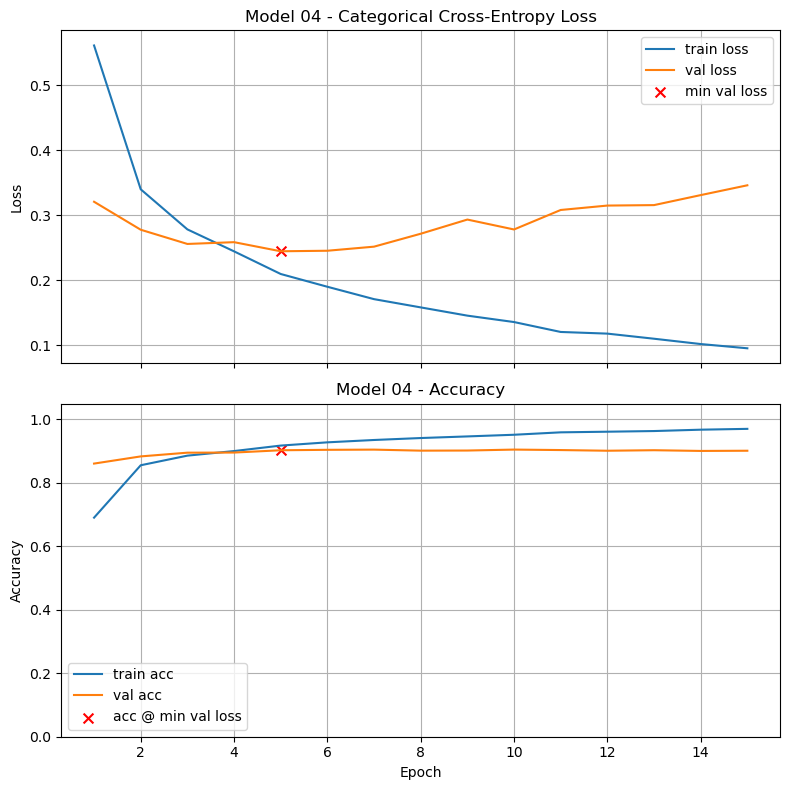

Final Training Loss:            0.0956
Final Training Accuracy:        0.9705
Final Validation Loss:          0.3460
Final Validation Accuracy:      0.9015
Validation Accuracy @ Min Loss: 0.9030

Best val_accuracy Overall: 0.9051 @ epoch 9

Execution Time: 00:16:52


In [20]:
model_04 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_04,title="Model 04",verbose=1)

**Model 05 – CNN Text Model:**

A convolutional baseline; fast and often surprisingly strong.


Model 05

Epoch 1/100


/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6492 - loss: 0.6971 - val_accuracy: 0.8480 - val_loss: 0.3463
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8305 - loss: 0.3913 - val_accuracy: 0.8752 - val_loss: 0.2957
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8786 - loss: 0.2913 - val_accuracy: 0.8856 - val_loss: 0.2738
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9036 - loss: 0.2377 - val_accuracy: 0.8911 - val_loss: 0.2714
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9213 - loss: 0.2007 - val_accuracy: 0.8940 - val_loss: 0.2769
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9374 - loss: 0.1634 - val_accuracy: 0.8947 - val_loss: 0.2818
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9572 - loss: 0.1192 - val_accuracy: 0.8919 - val_loss: 0.3093
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9585 - loss: 0.1097 - val_accuracy

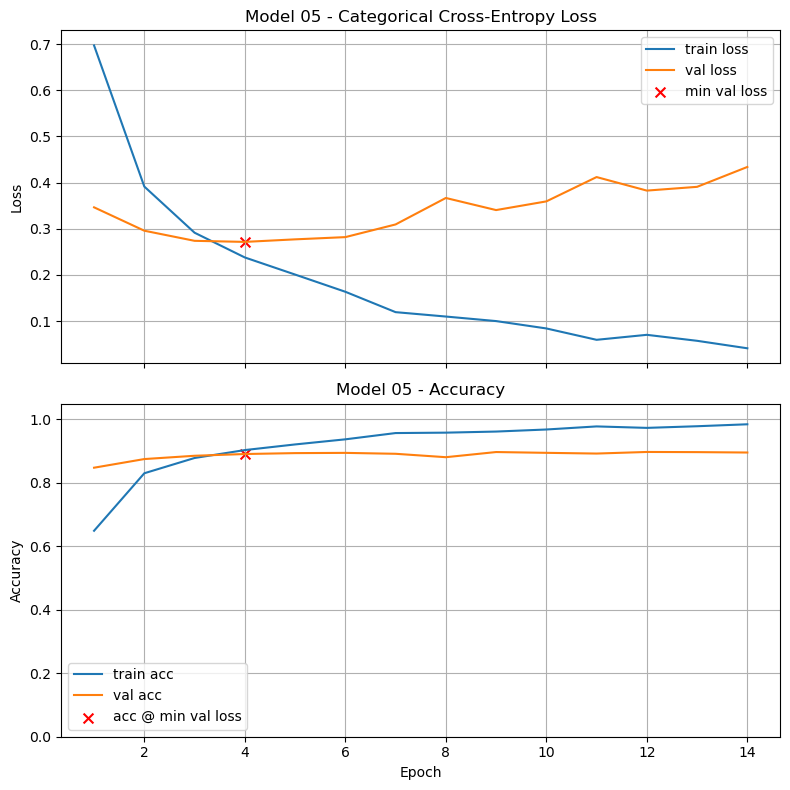

Final Training Loss:            0.0409
Final Training Accuracy:        0.9849
Final Validation Loss:          0.4338
Final Validation Accuracy:      0.8959
Validation Accuracy @ Min Loss: 0.8911

Best val_accuracy Overall: 0.8976 @ epoch 11

Execution Time: 00:01:02


In [21]:
model_05 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    SpatialDropout1D(0.2),
    Conv1D(128, 5, padding='valid', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_05,title="Model 05",verbose=1)


**Model 06 – GRU (Bidirectional)**

Slightly faster than LSTM; comparable performance.


Model 06

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 145ms/step - accuracy: 0.5109 - loss: 0.6998 - val_accuracy: 0.5301 - val_loss: 0.6866
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.5198 - loss: 0.6928 - val_accuracy: 0.5374 - val_loss: 0.6836
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.5398 - loss: 0.6922 - val_accuracy: 0.5765 - val_loss: 0.6425
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.8002 - loss: 0.4312 - val_accuracy: 0.8715 - val_loss: 0.3035
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.8836 - loss: 0.2921 - val_accuracy: 0.8938 - val_loss: 0.2617
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.9069 - loss: 0.2414 - val_accuracy: 0.9022 - val_loss: 0.2501
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.9188 - loss: 0.2128 - val_accuracy: 0.9040 - val_loss: 0.2463
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accurac

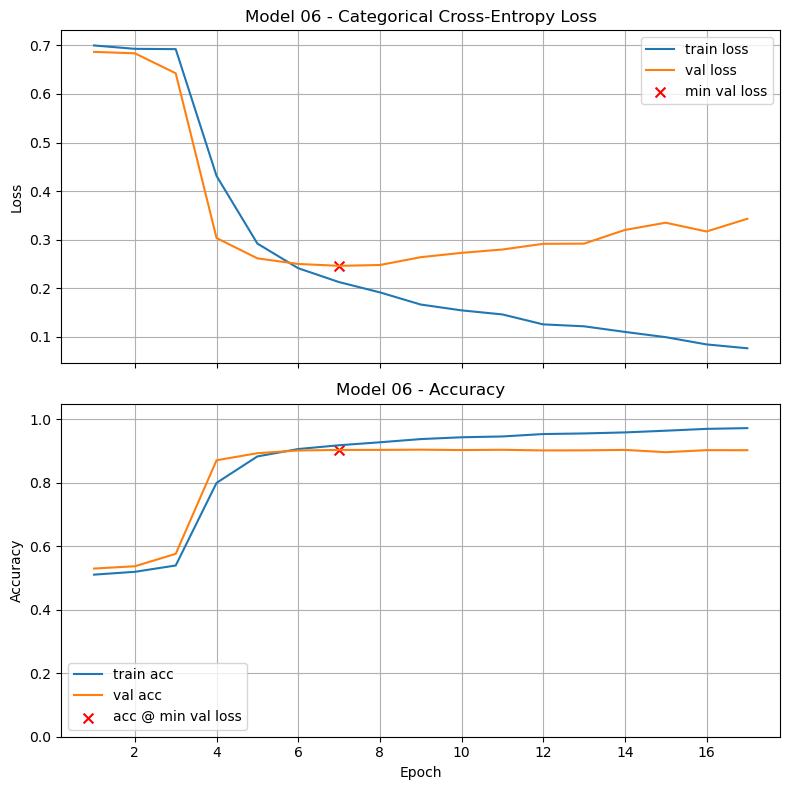

Final Training Loss:            0.0766
Final Training Accuracy:        0.9728
Final Validation Loss:          0.3431
Final Validation Accuracy:      0.9031
Validation Accuracy @ Min Loss: 0.9040

Best val_accuracy Overall: 0.9049 @ epoch 8

Execution Time: 00:10:08


In [22]:
model_06 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    SpatialDropout1D(0.2),
    Bidirectional(GRU(128, dropout=0.3, return_sequences=False)),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_06,title="Model 06",verbose=1)

**Model 7 -- with Attention Pooling**

Looking ahead to next week where we study "Attention is all you need"!


Model 07

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 261ms/step - accuracy: 0.7410 - loss: 0.4917 - val_accuracy: 0.8796 - val_loss: 0.2901
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.8748 - loss: 0.2989 - val_accuracy: 0.8963 - val_loss: 0.2555
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 259ms/step - accuracy: 0.9022 - loss: 0.2444 - val_accuracy: 0.9078 - val_loss: 0.2342
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 259ms/step - accuracy: 0.9184 - loss: 0.2091 - val_accuracy: 0.9076 - val_loss: 0.2347
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.9307 - loss: 0.1827 - val_accuracy: 0.9036 - val_loss: 0.2507
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 259ms/step - accuracy: 0.9430 - loss: 0.1574 - val_accuracy: 0.9068 - val_loss: 0.2616
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.9525 - loss: 0.1323 - val_accuracy: 0.9051 - val_loss: 0.2874
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 259ms/step - accurac

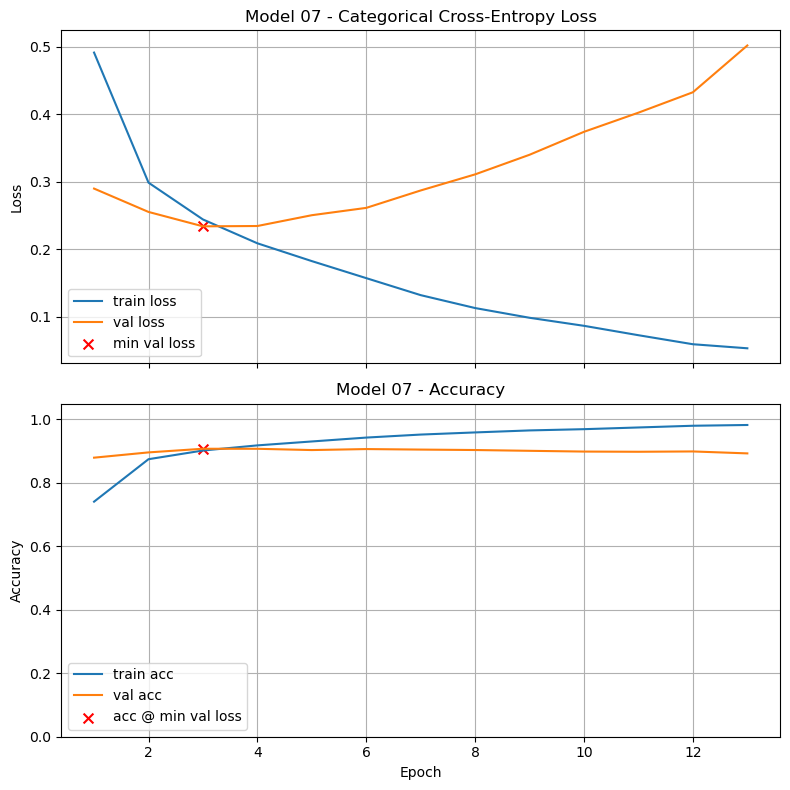

Final Training Loss:            0.0535
Final Training Accuracy:        0.9827
Final Validation Loss:          0.5022
Final Validation Accuracy:      0.8931
Validation Accuracy @ Min Loss: 0.9078

Best val_accuracy Overall: 0.9078 @ epoch 2

Execution Time: 00:14:15


In [23]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D, Bidirectional, LSTM,
    Dense, Dropout
)

class AttentionPooling1D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.score = tf.keras.layers.Dense(1, use_bias=False)
        self.supports_masking = True

    def call(self, x, mask=None):
        # x: (batch, time, features)
        scores = self.score(x)  # (batch, time, 1)
        if mask is not None:
            mask = tf.cast(mask, x.dtype)          # (batch, time)
            mask = tf.expand_dims(mask, axis=-1)   # (batch, time, 1)
            scores = scores + (1.0 - mask) * (-1e9)
        weights = tf.nn.softmax(scores, axis=1)    # (batch, time, 1)
        context = tf.reduce_sum(weights * x, axis=1)  # (batch, features)
        return context

    def compute_mask(self, inputs, mask=None):
        # We’ve collapsed the time dimension -> no mask to propagate.
        return None

# Rebuild model with the fixed layer
model_07 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,    # e.g., 100
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)),
    AttentionPooling1D(),                             # attention over timesteps
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# (Optional but recommended) stable optimizer defaults for RNNs
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
model_07.compile(optimizer=optimizer, loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# train_and_test(model_07, title="Model 07", verbose=1)


train_and_test(model_07, title="Model 07", verbose=1)


#### Picking best model and trying smaller LR


Model 04 LR

Epoch 1/100


/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_2' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_2' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 258ms/step - accuracy: 0.5240 - loss: 0.7013 - val_accuracy: 0.6658 - val_loss: 0.6601
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 258ms/step - accuracy: 0.6130 - loss: 0.6518 - val_accuracy: 0.7318 - val_loss: 0.5389
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 258ms/step - accuracy: 0.7051 - loss: 0.5695 - val_accuracy: 0.7885 - val_loss: 0.4544
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 258ms/step - accuracy: 0.7603 - loss: 0.4966 - val_accuracy: 0.8206 - val_loss: 0.4056
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 258ms/step - accuracy: 0.7868 - loss: 0.4577 - val_accuracy: 0.8364 - val_loss: 0.3956
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 258ms/step - accuracy: 0.8123 - loss: 0.4166 - val_accuracy: 0.8503 - val_loss: 0.3658
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 258ms/step - accuracy: 0.8215 - loss: 0.3986 - val_accuracy: 0.8536 - val_loss: 0.3502
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 258ms/step - accuracy: 0.8323 - loss: 0.381

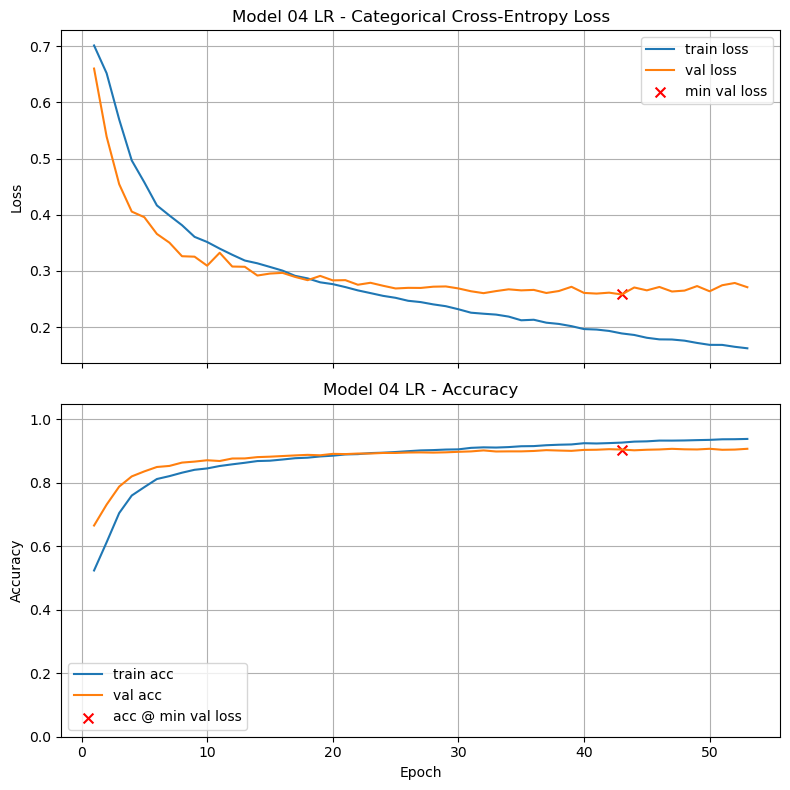

Final Training Loss:            0.1622
Final Training Accuracy:        0.9387
Final Validation Loss:          0.2710
Final Validation Accuracy:      0.9076
Validation Accuracy @ Min Loss: 0.9053

Best val_accuracy Overall: 0.9076 @ epoch 49

Execution Time: 00:57:16


In [24]:
model_04_lr = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_04_lr,lr_schedule=1e-4,title="Model 04 LR",verbose=1)

#### Picking best model and trying Reduce on Plateau


Model_04_ROP

Epoch 1/100


/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 258ms/step - accuracy: 0.6747 - loss: 0.5756 - val_accuracy: 0.8491 - val_loss: 0.3395 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 0.8491 - loss: 0.3482 - val_accuracy: 0.8848 - val_loss: 0.2713 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 0.8862 - loss: 0.2785 - val_accuracy: 0.8995 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 0.9051 - loss: 0.2369 - val_accuracy: 0.9054 - val_loss: 0.2438 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 256ms/step - accuracy: 0.9208 - loss: 0.2046 - val_accuracy: 0.9055 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 0.9330 - loss: 0.1811 - val_accuracy: 0.9064 - val_loss: 0.2562 - learning_rate: 0.0010
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 258ms/step - accuracy: 0.9395 -

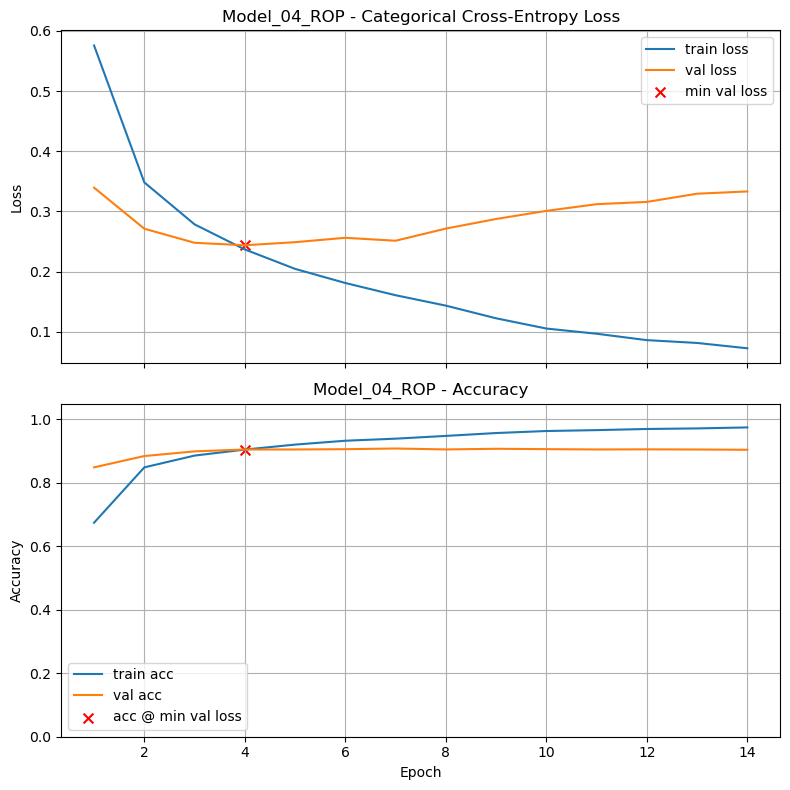

Final Training Loss:            0.0727
Final Training Accuracy:        0.9750
Final Validation Loss:          0.3332
Final Validation Accuracy:      0.9045
Validation Accuracy @ Min Loss: 0.9054

Best val_accuracy Overall: 0.9085 @ epoch 6

Execution Time: 00:15:13


In [25]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

model_04_ROP = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

train_and_test(model_04_ROP,title="Model_04_ROP",callbacks=[reduce_lr],verbose=1)



#### Attention model with reduced learning rate


Model 07 LR

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 261ms/step - accuracy: 0.5657 - loss: 0.6787 - val_accuracy: 0.6889 - val_loss: 0.6213
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.6776 - loss: 0.5942 - val_accuracy: 0.7586 - val_loss: 0.5020
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 261ms/step - accuracy: 0.7517 - loss: 0.5061 - val_accuracy: 0.7754 - val_loss: 0.4858
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 261ms/step - accuracy: 0.7836 - loss: 0.4550 - val_accuracy: 0.7959 - val_loss: 0.4495
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 261ms/step - accuracy: 0.8086 - loss: 0.4203 - val_accuracy: 0.8354 - val_loss: 0.3681
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 261ms/step - accuracy: 0.8261 - loss: 0.3907 - val_accuracy: 0.8341 - val_loss: 0.3715
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 261ms/step - accuracy: 0.8374 - loss: 0.3701 - val_accuracy: 0.8471 - val_loss: 0.3437
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 261ms/step - accu

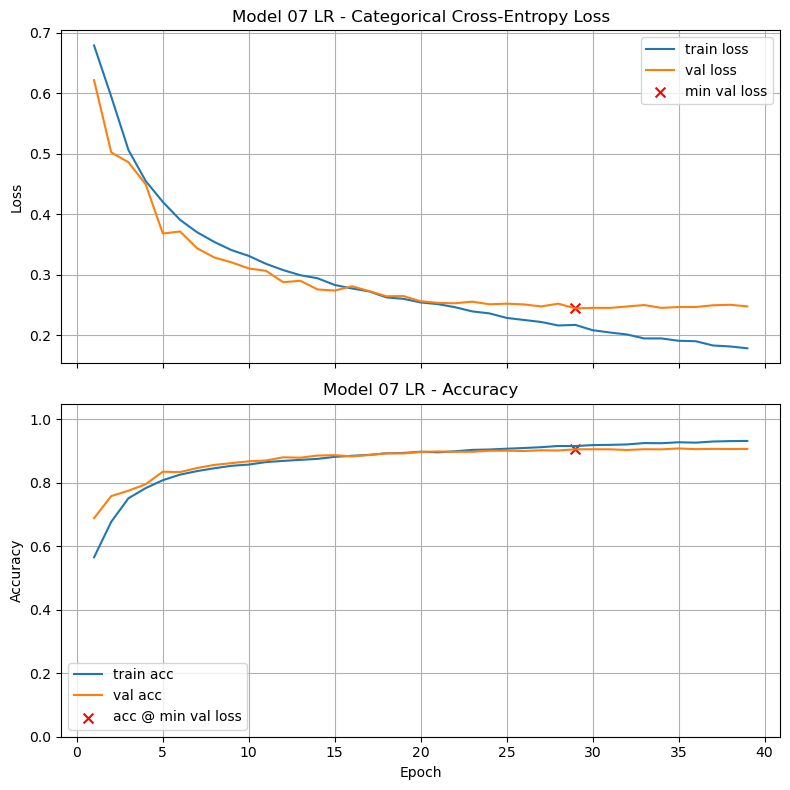

Final Training Loss:            0.1786
Final Training Accuracy:        0.9324
Final Validation Loss:          0.2478
Final Validation Accuracy:      0.9071
Validation Accuracy @ Min Loss: 0.9060

Best val_accuracy Overall: 0.9087 @ epoch 34

Execution Time: 00:42:51


In [26]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D, Bidirectional, LSTM,
    Dense, Dropout
)

class AttentionPooling1D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.score = tf.keras.layers.Dense(1, use_bias=False)
        self.supports_masking = True

    def call(self, x, mask=None):
        # x: (batch, time, features)
        scores = self.score(x)  # (batch, time, 1)
        if mask is not None:
            mask = tf.cast(mask, x.dtype)          # (batch, time)
            mask = tf.expand_dims(mask, axis=-1)   # (batch, time, 1)
            scores = scores + (1.0 - mask) * (-1e9)
        weights = tf.nn.softmax(scores, axis=1)    # (batch, time, 1)
        context = tf.reduce_sum(weights * x, axis=1)  # (batch, features)
        return context

    def compute_mask(self, inputs, mask=None):
        # We’ve collapsed the time dimension -> no mask to propagate.
        return None

# Rebuild model with the fixed layer
model_07_lr = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,    # e.g., 100
        weights    = [embedding_matrix],
        mask_zero  = True,
        trainable  = True
    ),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)),
    AttentionPooling1D(),                             # attention over timesteps
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])



train_and_test(model_07_lr, lr_schedule=1e-4,title="Model 07 LR", verbose=1)


In [27]:
print_results()

Model 07                                	0.9078	3
Model 07 LR                             	0.9060	29
Model_04_ROP                            	0.9054	4
Model 04 LR                             	0.9053	43
Model 06                                	0.9040	7
Model 04                                	0.9030	5
Model 01                                	0.8936	10
Model 05                                	0.8911	4
Model 03                                	0.8866	7
Model 02                                	0.8846	7
